# Jupyter Notebook file for training the model based on the [FABRIC STAIN DATASET](https://www.kaggle.com/datasets/priemshpathirana/fabric-stain-dataset).



We could also use this: https://www.kaggle.com/datasets/angelolmg/tilda-400-64x64-patches?select=oil+spot

Check this out, the github project that used the above dataset. They then created the fabric stain dataset to val their model: https://github.com/PrimeshShamilka/fabric_defect_detector#training-the-stain-detection-model

- https://github.com/lstearns86/clothing-pattern-dataset/tree/master is a dataset of clothing patterns, without stains. 


- https://universe.roboflow.com/college-wtlzk/fabric-stain-detection is a dataset of stains, I'm thinking they're stains based off the fabric stain dataset.

- Look into YOLO forehead

- Here's another paper about stain detection using YOLO3: https://www.researchgate.net/publication/340019698_Fabric_defect_detection_using_the_improved_YOLOv3_model





Lets start by importing our main libraries

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import shutil

<div class="alert alert-block alert-info">
This code block is an optional visualization
</div>

I was confused on what the annotations of the images meant. I asked chatGPT and it displayed the following:
> The annotations provided appear to be in the format commonly used for object detection tasks, particularly for training models like R-CNN. Each line corresponds to one annotation and includes several values that describe the location and size of the bounding box around each stain. Let's break down the format step by step.
> 
> Typically, the format for each annotation is:
> 
> `<class> <x_center> <y_center> <width> <height>`
> 
> Where:
> - `<class>`: The class label (in your case, 0 likely corresponds to the stain class).
> - `<x_center>`: The normalized x-coordinate of the center of the bounding box (relative to the width of the image).
> - `<y_center>`: The normalized y-coordinate of the center of the bounding box (relative to the height of the image).
> - `<width>`: The normalized width of the bounding box (relative to the width of the image).
> - `<height>`: The normalized height of the bounding box (relative to the height of the image).
> 
> For your example:
> 
> 1. `0 0.121220 0.198253 0.241431 0.239247`
>    - Class: 0
>    - x_center: 0.121220
>    - y_center: 0.198253
>    - Width: 0.241431
>    - Height: 0.239247
>
> 2. `0 0.360887 0.579637 0.216734 0.269489`
>    - Class: 0
>    - x_center: 0.360887
>    - y_center: 0.579637
>    - Width: 0.216734
>    - Height: 0.269489
>
> 3. `0 0.890121 0.339718 0.219758 0.242608`
>    - Class: 0
>    - x_center: 0.890121
>    - y_center: 0.339718
>    - Width: 0.219758
>    - Height: 0.242608
>
> To visualize this on an image, you'd convert these normalized values back to pixel values based on the actual dimensions of the image. For instance, if your image has a width of `W` and a height of `H`, you would compute:
>
> - Center x-coordinate in pixels: `x_center * W`
> - Center y-coordinate in pixels: `y_center * H`
> - Width in pixels: `width * W`
> - Height in pixels: `height * H`
>
> These calculations will give you the bounding boxes in pixel coordinates which can then be drawn on the image to visualize where the stains are located. Would you like further assistance with visualizing these annotations on an example image?

Lets see what happens when we display this using matplotlib

[[181 182 186 ... 173 174 175]
 [180 181 186 ... 172 173 173]
 [179 181 187 ... 171 171 171]
 ...
 [182 206 210 ... 183 188 183]
 [179 203 211 ... 184 185 187]
 [185 201 204 ... 184 187 187]]


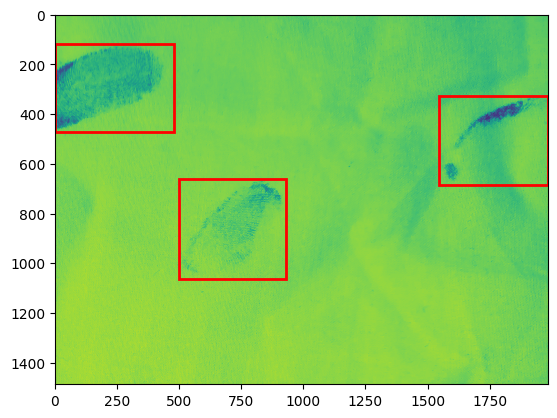

: 

In [5]:
#Running this segment is optional


# Load the image
image_path = os.path.join('fabric_stain_dataset', 'images', 'stain', '2.jpg')  
image = Image.open(image_path)
image = np.array(image)

# Read the annotations from the file
annotations_path = os.path.join('fabric_stain_dataset', 'annotations', 'stain', '2.txt')  
annotations = []

with open(annotations_path, 'r') as file:
    for line in file:
        parts = line.strip().split()
        annotations.append([float(part) for part in parts])

# Get the image dimensions
image_height, image_width = image.shape


# Convert normalized coordinates to pixel values
boxes = []
for annotation in annotations:
    class_id, x_center, y_center, width, height = annotation
    x_center *= image_width
    y_center *= image_height
    width *= image_width
    height *= image_height
    
    x_min = int(x_center - width / 2)
    y_min = int(y_center - height / 2)
    x_max = int(x_center + width / 2)
    y_max = int(y_center + height / 2)
    
    boxes.append((x_min, y_min, x_max, y_max))

# Plot the image with bounding boxes
fig, ax = plt.subplots(1)
ax.imshow(image)

for box in boxes:
    x_min, y_min, x_max, y_max = box
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, color='red', linewidth=2)
    ax.add_patch(rect)

plt.show()

### Now we can see how the annotations work on the stain dataset
Huzzah!   
Now let's work on getting our dataset ready



In [8]:
annotation_dir = os.path.join('fabric_stain_dataset', 'annotations', 'stain')
total_stains = 0
max_stains = 0

for annotation_file in os.listdir(annotation_dir):
    annotation_file = os.path.join(annotation_dir, annotation_file)
    with open(annotation_file, 'r') as file:
        num_stains = len(file.readlines())
        total_stains += num_stains
        if num_stains > max_stains:
            max_stains = num_stains

print("Total number of stains:", total_stains)
print("Maximum number of stains in a single image:", max_stains)

Total number of stains: 870
Maximum number of stains in a single image: 14


### As you can see, there are more than one stain per image. This makes splitting the data tricky.

So we'll just aproximate the train-test split.

<div class="alert alert-block alert-info">
 You only have to run this segment once to get the dataset split
</div>

In [9]:
#Because there are multiple stains per iamge, this gets a bit tricky
source_dir = os.path.join('fabric_stain_dataset', 'images', 'stain')
train_dir = os.path.join('fabric_stain_dataset', 'split_images', 'train')
val_dir = os.path.join('fabric_stain_dataset', 'split_images', 'val')
annotation_dir = os.path.join('fabric_stain_dataset', 'annotations', 'stain')

# Create the balanced dataset folders if it doesn't exist
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
else:
    # Remove all the files in the folder
    for file_name in os.listdir(train_dir):
        file_path = os.path.join(train_dir, file_name)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")
if not os.path.exists(val_dir):
    os.makedirs(val_dir)
else:
    # Remove all the files in the folder
    for file_name in os.listdir(val_dir):
        file_path = os.path.join(val_dir, file_name)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")


# Ensure the target directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)


#We'll be using an 80-20 split for the training and validating datasets. this is pretty standard.
train_test_split = 0.8 

image_files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]

# Shuffle the list to ensure randomness
np.random.shuffle(image_files)

#Find the total number of stains in the dataset
total_stains = 0
for annotation_file in os.listdir(annotation_dir):
    annotation_file = os.path.join(annotation_dir, annotation_file)
    with open(annotation_file, 'r') as file:
        num_stains = len(file.readlines())
        total_stains += num_stains

num_train_stains = int(total_stains * 0.8)
current_train_stains = 0


for img in image_files:
    # Get the annotation file for the image
    annotation_file = os.path.join(annotation_dir, img.replace('.jpg', '.txt'))
    with open(annotation_file, 'r') as file:
        num_stains = len(file.readlines())
        if current_train_stains + num_stains <= num_train_stains:
            current_train_stains += num_stains
            shutil.copy(os.path.join(source_dir, img), os.path.join(train_dir, img))
        else:
            shutil.copy(os.path.join(source_dir, img), os.path.join(val_dir, img))

num_train_imgs = len(os.listdir(train_dir))
num_val_imgs = len(os.listdir(val_dir))

print(f"Moved {num_train_imgs} images with {current_train_stains} stains to {train_dir}")
print(f"Moved {num_val_imgs} images with {total_stains - current_train_stains} to {val_dir}")
print(f"Train val split is {current_train_stains / total_stains * 100:.2f}% - {(total_stains - current_train_stains) / total_stains * 100:.2f}%")

Moved 323 images with 696 stains to fabric_stain_dataset\split_images\train
Moved 75 images with 174 to fabric_stain_dataset\split_images\val
Train val split is 80.00% - 20.00%


## We should now have our split dataset in <b>fabric_stain_dataset/split_images</b>
### Now onto data processing

In [3]:

train_dir = os.path.join('fabric_stain_dataset', 'split_images', 'train')
val_dir = os.path.join('fabric_stain_dataset', 'split_images', 'val')

train_data = []
train_annotations = []

for img_name in os.listdir(train_dir):
    if os.path.isfile(os.path.join(train_dir, img_name)):
        image_path = os.path.join(train_dir, img_name)
        image = Image.open(image_path)
        image = np.array(image) / 255.0 # Convert the image to a numpy array and normalize it